<a href="https://colab.research.google.com/github/Hainguyendangduc/DeepLearning_PJ/blob/main/handwritten_number_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets.mnist import load_data
(X_train, y_train),(X_test, y_test) = load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)


In [ ]:
X_train[0][:,:,None].shape

(28, 28, 1)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

inp = Input(shape=(28,28,1))
x = Conv2D(filters=8, kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(units=32, activation='relu')(x)
x = Dense(units=2)(x)

cnn = Model(inputs=inp, outputs=x)

img1 = Input(shape=(28,28,1))
img2 = Input(shape=(28,28,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1-f2), axis=1, keepdims=True))

model = Model(inputs=[img1, img2], outputs=d)
model.summary()
cnn.summary()

def loss(y_true, y_pred):
  proba = K.exp(-K.square(y_pred))
  return -K.mean(y_true*K.log(proba)+(1-y_true)+K.log(1-proba))

def loss1(y_true, y_pred):
  return K.mean(y_true*K.square(y_pred)+(1-y_true)*K.square(K.maximum(1.0-y_pred,0)))

model.compile(optimizer='adam', loss=loss1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 2)            43442       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 2)            0           ['model[0][0]',            

Batch size: 160
(28, 28, 1)
Pair label: 0.0


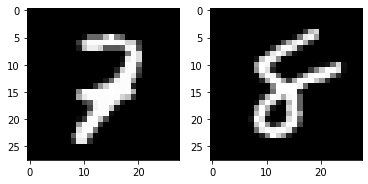

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def generator(X, y, k=8):
  unique_labels = np.unique(y)

  while True:
    X1 = []
    X2 = []
    y_batch = []
    for label in unique_labels:
      label_idx = np.where(y==label)[0]
      other_labels = set(unique_labels)-{label}

      for i in range(k):
        i1 = np.random.choice(label_idx)
        i2 = np.random.choice(label_idx)
        while i1==i2:
          i2 = np.random.choice(label_idx)
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(1.0)

        i1 = np.random.choice(label_idx)
        my_label = np.random.choice(list(other_labels))
        i2 = np.random.choice(list(np.where(y == my_label)[0]))
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(0.0)
        
    yield [np.array(X1)/255., np.array(X2)/255.], np.array(y_batch)
    
for pair, y in generator(X_test, y_test):
  print('Batch size:', len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label:', y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28),cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28),cmap='gray') 
  break
    

In [ ]:
history = model.fit(generator(X_train, y_train, k=32), 
                    steps_per_epoch=5, 
                    epochs=10, 
                    validation_data=generator(X_test, y_test, k=8), 
                    validation_steps=5)

Epoch 1/10
5/5 [==============================] - 15s 336ms/step - loss: 0.2727 - val_loss: 0.2063
Epoch 2/10
5/5 [==============================] - 1s 319ms/step - loss: 0.2149 - val_loss: 0.1841
Epoch 3/10
5/5 [==============================] - 1s 321ms/step - loss: 0.1850 - val_loss: 0.1662
Epoch 4/10
5/5 [==============================] - 2s 448ms/step - loss: 0.1720 - val_loss: 0.1639
Epoch 5/10
5/5 [==============================] - 1s 322ms/step - loss: 0.1594 - val_loss: 0.1504
Epoch 6/10
5/5 [==============================] - 1s 324ms/step - loss: 0.1533 - val_loss: 0.1546
Epoch 7/10
5/5 [==============================] - 1s 327ms/step - loss: 0.1452 - val_loss: 0.1472
Epoch 8/10
5/5 [==============================] - 1s 323ms/step - loss: 0.1350 - val_loss: 0.1592
Epoch 9/10
5/5 [==============================] - 1s 319ms/step - loss: 0.1393 - val_loss: 0.1311
Epoch 10/10
5/5 [==============================] - 1s 325ms/step - loss: 0.1323 - val_loss: 0.1276


dict_keys(['loss', 'val_loss'])


Text(0, 0.5, 'loss')

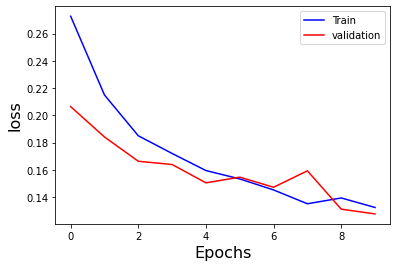

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'], label='Train',c='b')
plt.plot(history.history['val_loss'], label='validation',c='r')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)

Batch size: 160
Pair label: 1.0
Distance: [0.303498]
Distance by features: [0.303498]


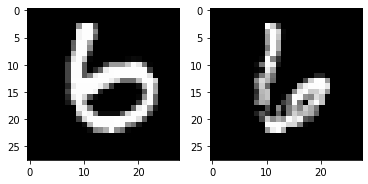

In [ ]:
for pair, y in generator(X_test, y_test):
  y_pred = model.predict(pair)
  print('Batch size:', len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label:',y[idx])
  print('Distance:', y_pred[idx])

  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2, axis=1, keepdims=True))
  print("Distance by features:", d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(28,28),cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(28,28),cmap='gray')
  break

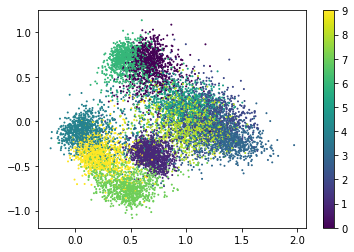

In [ ]:
f = cnn.predict(X_test/255.)
p = plt.scatter(f[:,0],f[:,1],c=y_test, s=1)
plt.colorbar(p)

In [ ]:
cnn.save('cnn_loss1.h5')

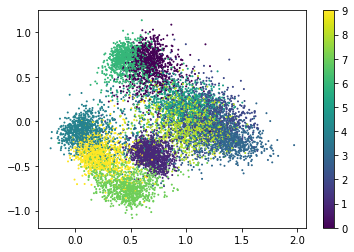

In [ ]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test/255.)
p=plt.scatter(f1[:,0],f1[:,1], c=y_test, s=1)
plt.colorbar(p)

In [ ]:
i = 0
y_true = []
y_pred = []
for pair, y in generator(X_test, y_test):
  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2, axis=1, keepdims=True))
  y_pred +=list(d.ravel())
  y_true +=list(y)
  i += 1
  if i>500:
    break

(array([1.06882204e-01, 3.02474268e-01, 4.92805797e-01, 6.30772472e-01,
        7.34546260e-01, 8.22777656e-01, 8.97379989e-01, 9.25117283e-01,
        9.50701529e-01, 9.74613090e-01, 9.33485606e-01, 7.46262442e-01,
        5.11934601e-01, 2.94822682e-01, 1.60203728e-01, 7.02983525e-02,
        2.12808181e-02, 5.02131089e-03, 1.67377030e-03, 4.78220085e-04]),
 array([0.00264654, 0.10699221, 0.21133786, 0.31568354, 0.4200292 ,
        0.52437484, 0.6287205 , 0.7330662 , 0.8374118 , 0.9417575 ,
        1.0461031 , 1.1504488 , 1.2547945 , 1.3591402 , 1.4634858 ,
        1.5678315 , 1.6721772 , 1.7765228 , 1.8808684 , 1.9852141 ,
        2.0895598 ], dtype=float32),
 <a list of 20 Patch objects>)

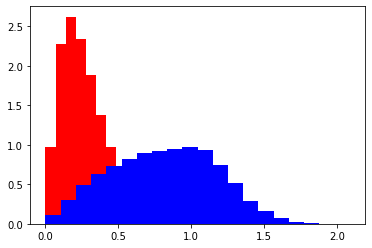

In [ ]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances, color='r', density=True, bins=20)
plt.hist(negative_distances, color='b', density=True, bins=20)

In [ ]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82     40080
         1.0       0.80      0.87      0.83     40080

    accuracy                           0.83     80160
   macro avg       0.83      0.83      0.83     80160
weighted avg       0.83      0.83      0.83     80160



(2560, 1920, 3)
(2560, 1920, 3)


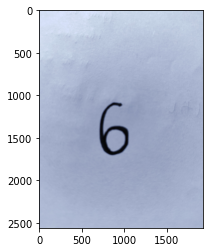

In [ ]:
import cv2
img = cv2.imread('/content/bd1d65d3dca11cff45b0.jpg')
print(img.shape)
plt.imshow(img)
print(img.shape)
plt.imshow(img)


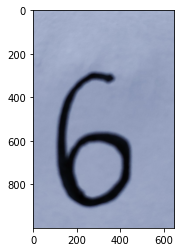

In [ ]:
img = img[800:1800, 600:1250] #[y1:y2, x1:x2]
plt.imshow(img)

In [ ]:
img = cv2.resize(img, (28, 28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1,1))
y_train = encoder.transform(y_train.reshape(-1,1)).toarray()
print(y_train[2])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
inp = Input(shape = (28,28,1))
cnn = Conv2D(filters=32, kernel_size = 3, activation='relu')(inp)
pooling = MaxPooling2D(pool_size=(2,2))(cnn)
drop = Dropout(0.2)(pooling)

cnn = Conv2D(filters=16, kernel_size=3, activation='relu')(drop)
pooling = MaxPooling2D(pool_size=(2,2))(cnn)
drop = Dropout(0.2)(pooling)

f = Flatten()(drop)
fc1=Dense(units=32, activation='relu')(f)
fc2=Dense(units=16, activation='relu')(fc1)
out=Dense(units=10, activation='softmax')(fc2)

model = Model(inputs= inp, outputs = out)
model.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                       

In [ ]:
b = np.array([img/255.])

In [ ]:
pred = model.predict(b)

In [ ]:
pred

array([[0.10719883, 0.08521812, 0.09423399, 0.11270846, 0.11900645,
        0.09817161, 0.09399137, 0.08189432, 0.09448227, 0.11309458]],
      dtype=float32)

In [ ]:
np.argmax(pred)

4